In [1]:
import numpy as np
import bfm
import neal
from dwave.samplers import SimulatedAnnealingSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools
import pprint
import numpy.linalg as linalg

In [2]:
# Nbits (列数)
N = 16
# 反復回数
N_iter = 600
# 初期学習データ (行数)
N_initial_samples = 10

# epoch数: 2000
# 学習率: 0.01
# 1回に作られるサンプル数: 3

sampler = SimulatedAnnealingSampler()
sampler.parameters["seed"] = 0



### QUBO模型の定義

QUBOとはQuadratic Unconstrained Binary Optimizationの略で、制約条件なし0-1整数二次計画問題のことです。

QUBO模型は以下のような形のバイナリ変数の多項式関数で表されます。

$
\displaystyle H = \sum_{i<j} J_{ij} q_i q_j + \sum_i h_i q_i \quad q_i\in\{0, +1 \}
$

HOBO(Higher Order Binary Optimization)

$
\displaystyle H = \sum_{i<j<k} J_{ijk} q_i q_j q_k + \sum_i h_i q_i \quad q_i\in\{0, +1 \}
$

(FixstarsAmplify 1-tutorial-basic.jpynbより引用)

In [3]:
## オリジナルブラックボックス関数

# QUBOをブラックボックス関数として設定
# 上記に従ってコスト関数を設定

# def cost_function(x, J, h):
#     cost = 0

#     # 1次の項について
#     for i in range(N):
#         cost += h[i] * x[i]

#     # 2次の項について
#     # i = jのときは対角成分すなわち一次の項なので計算してはいけない。よってfor j in range(i+1, N):としてi, jが一致しないように変更(2023/05/12)
#     for i in range(N):
#         for j in range(i+1, N):
#             cost += J[i, j] * x[i] * x[j]

#     return cost

# もっとシンプルに表現
def cost_function(x, Q):
    cost = 0

    # i, jが同じ場合は(x[i])^2となるが、Binaryなのでxは0か1。よって(x[i])^2 = x[i]なのでfor j in range(N)としても問題ない。i, jが一致する場合は自動的に一次の項におけるエネルギー値が計算される。
    for i in range(N):
        for j in range(N):
            cost += Q[i, j] * x[i] * x[j]

    return cost

In [4]:
# Create initial samples
# 初期入力データを作成する

# random.default_rng(0)ではシード値0でdefault_rngのインスタンスrngを作る
rng = np.random.default_rng(0)

# xs_realとして、N個(行) × Nビット(列)の0, 1の整数乱数配列を生成する。
# xsはN_initial_samples個(行) × Nビット(列)の0, 1の整数乱数配列とする。
xs = rng.integers(2, size=(N_initial_samples, N))
# print(f"xs_real: {xs_real}")
print(f"xs: {xs}")

# QUBO行列(対角成分: 1次の項である局所磁場h, 非対角成分: 2次の項である相互作用パラメータJ　で構成される)を作成
Q = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            Q[i, j] = rng.uniform(-1, 1)
        else:
            val = rng.uniform(-1 ,1)
            Q[i, j] = val
            Q[j, i] = val

print(f"Q: {Q}")
print(f"Qのサイズ: {Q.size}")

unique_Q, counts = np.unique(Q, return_counts=True)
if len(unique_Q[counts == 1]) == N:
    print(f"重複していない要素の数: {len(unique_Q[counts == 1])} \t(正しいQUBOが生成されています。)")
else:
    print(f"Error! \t(重複していない要素の数: {len(unique_Q[counts == 1])})")
# # J, hそれぞれ1に設定
# J = np.ones((N, N))
# h = np.ones(N)

# コスト関数の返り値を求める
# itertools.product(range(a), repeat=N)とすることで、a未満の自然数で構成されるNビット列を生成できる。
ys_all =[cost_function(x, Q)for x in itertools.product(range(2), repeat=N)]
ys = [(cost_function(x, Q)/abs(min(ys_all))) for x in xs]
print(f"ys: {ys}")

xs: [[1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0]
 [1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0]
 [1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1]
 [0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0]
 [1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1]
 [1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0]]
Q: [[ 5.15457691e-01 -7.02471976e-01  4.38439546e-01 -7.50890588e-01
  -1.86979327e-01 -2.38458983e-01  3.35778811e-01  4.68694548e-02
  -5.43526828e-05  7.37708589e-01 -6.34113351e-01  7.55057812e-01
  -7.22136642e-01  1.41369572e-01  1.38051709e-01  1.28825642e-01]
 [-7.02471976e-01  9.45257628e-01 -9.68016541e-01 -4.23338486e-01
   8.19917923e-01 -1.40451878e-01  9.16827264e-01 -8.22128720e-01
   4.88194959e-01  2.68139959e-01  9.26038280e-01 -8.26370256e-01
   4.07571539e-01 -8.12309693e-01  6.51914444e-01 -3.10021153e-02]
 [ 4.38439546e-01 -9.68016541e-01  5.15902005e-01  1.72246130e-01
  -9.13866223e-01 -2.23009063e-02  8.51429154e

### QUBO模型の定義

QUBOとはQuadratic Unconstrained Binary Optimizationの略で、制約条件なし0-1整数二次計画問題のことです。

QUBO模型は以下のような形のバイナリ変数の多項式関数で表されます。

$
\displaystyle H = \sum_{i<j} J_{ij} q_i q_j + \sum_i h_i q_i \quad q_i\in\{0, +1 \}
$

(FixstarsAmplify 1-tutorial-basic.jpynbより引用)

In [5]:
print(f"ys_all: {ys_all}")
print(f"min_ys_all: {min(ys_all)}")
print(f"min_ys: {min(ys)}")
print(f"len_ys: {len(ys)}")

ys_all: [0.0, 0.7668374672671239, -0.6187648791919635, -1.198455047377015, 0.1666400938469519, -0.9704696362005272, -1.3317951778790138, -3.815432543378669, 0.7275724821941698, 1.543104580812234, 1.0133016467381275, 0.48230610990401623, 2.481417505096161, 1.3930024063996223, 1.887476277106116, -0.5474664570425976, -0.7747726689188856, -1.2107418389338171, -2.8841036604241648, -4.666600465891273, 0.6869928584991529, -1.6529235088303813, -2.3020085255401286, -5.988452528321838, -0.1426118988497036, -0.5298864375136949, -1.3474488466190617, -3.0812510207352277, 2.906358557623374, 0.6151368216447801, 0.8218512173200139, -2.815898154110755, -0.2363704400675224, 2.3051780881163526, -0.5016148815426267, 0.693406011189073, 0.6664714460795615, 1.3040727769488336, -0.4784433879295449, -1.1873696925124482, 2.146552712819299, 4.736795872354113, 2.785802315080116, 4.029517839162756, 4.636599528021422, 5.322895490241635, 4.396178737748237, 3.7359470645162753, -0.8455031744657497, 0.49323871643606987

In [6]:
## FMA

dataset = bfm.Dataset("all")
# FMで作られるQUBO行列の元の形を作成
Q_model = np.zeros((N, N))
for x, l in zip(xs, ys):
    dataset.add(x.astype(int), l)

# Construct FM
# ビット数N, ハイパーパラメータK=8, seed=0でFM構築
model = bfm.FactorizationMachine(N, 8, seed = 0)
# Construct optimizer
optimizer = bfm.Optimizer("Adam")
# loss(学習誤差)を格納するリストを作成
list_loss =[]
# qubo行列のフロベニウスノルム差を計算
list_qubo_loss =[]
# 2000回のepochを行うFMをN_iter回まわす
for _ in range(N_iter):
    # Training
    # model.trainメソッドで2000回, 学習率0.01で学習
    # lossの中には訓練の中で得られる学習誤差が出力される
    loss = model.train(optimizer, dataset, epoch=2000, learning_rate=1.0e-2)
    list_loss.append(loss)
    
    # FMで作られるQUBO行列
    # モデル行列v_ik, v_jkの内積値を(i, j)に格納
    for (i, j), q in model.to_coefficients(False)[0].items():
        Q_model[i, j] = q
        Q_model[j, i] = q
    # 真QUBO行列とモデルQUBO行列のノルム差を計算し、list_qubo_lossにアペンド
    # qubo_loss = linalg.norm(Q)-linalg.norm(Q_model)
    qubo_loss = linalg.norm(Q_model-Q)
    list_qubo_loss.append(qubo_loss)
    # Get likely solutions
    qubo, _ , _ = model.to_coefficients()
    # 1回に3個のサンプルを生成する
    res = sampler.sample_qubo(qubo, num_reads=1)
    # Add the likely solutions to training dataset
    #res.record["sample"]に解が含まれており、解を2の補数表現に直して新しい解と2の補数表現をデータセットへ追加
    for x in res.record["sample"]:
        l = cost_function(x, Q)/abs(min(ys_all))
        #モデルに初期サンプルをアペンドするので、合計のサンプル数はN_iter×(1回に3個のサンプルを生成)+ N_initial_samplesとなる
        # datasetはset(集合型)で、重複を許さないから計算量を少なくできる。
        dataset.add(x.astype(int), l)
        # ysにlをアペンド
        ys.append(l)

In [7]:
print(len(list_loss))

600


In [8]:
print(f"ys: {ys}")
print(f"min_ys: {min(ys)}")
print(f"ys[-1]: {ys[-1]}")
print(res.record["sample"])
print(f"dataset: {dataset}")
print (dir(model))
print(type(xs))
# print(np.array(list_loss).shape)

ys: [0.8326206332287504, 1.117210742767411, -0.44489730500907854, 1.3752277732969715, 0.5049811044927565, -0.0008920168942541226, 0.47118538337406707, 0.8067831182729931, 1.5133230619010716, 0.31579402282282415, 0.41445127008499905, 0.49539315046948973, -0.31274210465129915, 0.14980230437335965, 0.4682748836163847, 0.0231451449066945, -0.30618832606256907, 0.27230312859995826, 1.0854075487495434, 0.056203234915357544, 0.7127500226880955, 0.129879813183714, 0.9269713715179931, 0.45246206569082476, 0.1036528987331511, 0.0070575659814432245, -0.2945678861131963, -0.3271081744505138, 0.6466172500012447, -0.07325948707260957, -0.00848079908912158, 0.5482793531847715, -0.3349048124025, -0.2107291894487221, 0.1055709275458999, 0.19136746537972427, -0.356341776929552, -0.5536547340489272, -0.09851843773147276, -0.18632282405208817, 0.4440531235682704, -0.1635996896953208, -0.123875040155027, 1.4898075772561694, 0.22842207567284373, 0.09576384863696787, -0.46334274780140444, 0.20968611527896316

In [9]:
model.predict(list(xs[0]))

[0.8241904973983765]

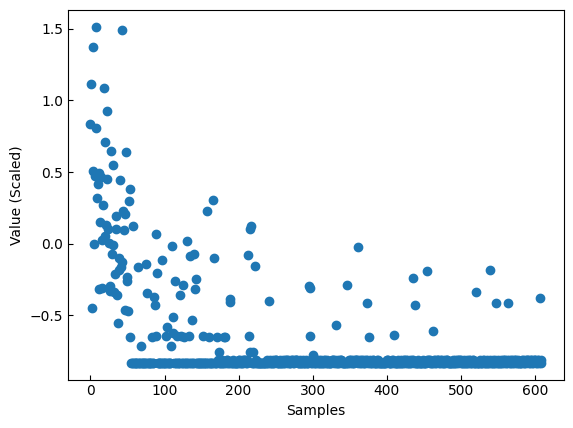

In [10]:
# サンプル数に対するValue値
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(ys, 'o')
plt.xlabel('Samples')
plt.ylabel('Value (Scaled)')
# plt.ylim([-1.0,1.0])
plt.show()

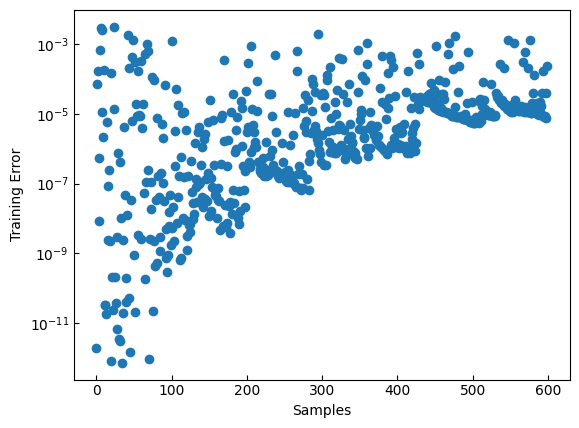

In [11]:
# サンプル数に対する学習誤差
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.yscale("log")
plt.plot(list_loss, 'o')
plt.xlabel('Samples')
plt.ylabel('Training Error')
plt.show()

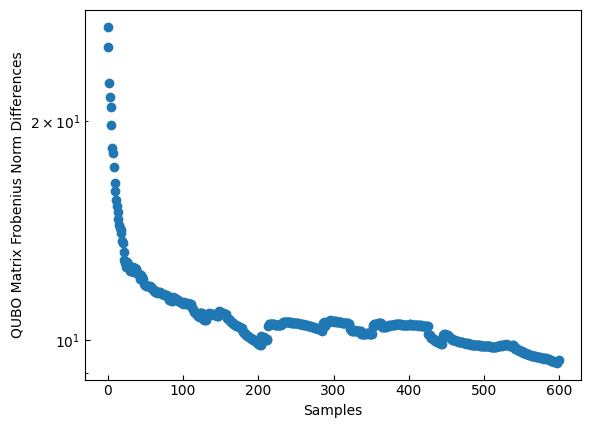

In [26]:
# QUBO行列のフロベニウスノルム差
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.yscale("log")
plt.plot(list_qubo_loss, 'o')
plt.xlabel('Samples')
plt.ylabel('QUBO Matrix Frobenius Norm Differences')
plt.show()

In [13]:
print(dataset)

In [14]:
# dataset.to_labels()で出力ysが得られる
# dataset.to_inputs()で入力xsが得られる。

# 得られた全てのysのリスト
print(dataset.to_labels())
# 得られた全てのysに対するxsのリスト。ただし1ビットずつ区切られているため、得られたサンプル数が得られる
print(dataset.to_inputs())

[0.6466172337532043, -0.2561950385570526, 0.27230313420295715, 1.0854074954986572, 0.19136746227741241, 0.12987981736660004, 0.548279345035553, -0.01977900229394436, -0.37542352080345154, 0.0671648234128952, -0.07515266537666321, -0.6443013548851013, -0.20047861337661743, -0.07325948774814606, 1.4898076057434082, -0.09851843863725662, -0.13822665810585022, -0.3271081745624542, -0.3694264888763428, -0.2892104983329773, -0.29456788301467896, -0.23221181333065033, 0.7127500176429749, 1.5133230686187744, -0.42436227202415466, 0.6397556662559509, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.8105955719947815, -0.81059557

In [15]:
# datasetは辞書型になっていて、キーが1, 1, 0, 0, 0, 1, ...の16ビットのinputs, それに対応する値が格納されている。これが610個(サンプル数個)あるのでshapeは[610, 16]
# ただし、datasetはRust言語で書かれているため、そのまま取り出すことができないことから、dataset.to_inputsとするとキーが1次元で全て表示されてしまう仕様になっている。
print(dataset.shape())
# reshapeするためにnumpyに変換している
numpy_dataset_inputs = np.array(dataset.to_inputs()).reshape(dataset.shape())
# # 16ビットの入力がサンプル数個あるnumpyとするためにreshapeを実行
# numpy_dataset_inputs_new = numpy_dataset_inputs.reshape(dataset.shape())

[610, 16]


In [16]:
list_dataset_inputs = list(numpy_dataset_inputs)

In [17]:
print(list_dataset_inputs)

[array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]), array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0]), array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0]), array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]), array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]), array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1]), array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]), array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]), array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]), array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]), array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]), array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]), array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]), array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]), array([1, 1, 1, 0, 0, 1, 0, 1,

In [18]:
# to_coefficients(False)とすると、規格化なしで（FMで得られるQUBOに対するモデル行列(v_ik, v_jk), FMの式における重みw_0, 規格化定数(規格化なしFalseでは1.0）が得られる。
model.to_coefficients(False)

({(6, 15): -0.27815747261047363,
  (13, 13): 0.3039509654045105,
  (3, 9): 0.0254798773676157,
  (1, 6): -0.13734175264835358,
  (5, 5): -0.162837952375412,
  (8, 8): 0.09678030759096146,
  (3, 11): 0.297085165977478,
  (2, 13): -0.46666863560676575,
  (10, 14): 0.11755142360925674,
  (11, 13): -0.22784486413002014,
  (8, 9): -0.2899380922317505,
  (7, 9): 0.2875898778438568,
  (5, 8): -0.027853261679410934,
  (9, 14): -0.21579857170581818,
  (5, 9): 0.2850751578807831,
  (7, 8): -0.06756886839866638,
  (3, 8): -0.013526804745197296,
  (6, 8): -0.13001668453216553,
  (1, 1): 0.014365984126925468,
  (2, 11): 0.5604777932167053,
  (12, 15): -0.20049633085727692,
  (12, 13): 0.11787176132202148,
  (14, 15): -0.2619573175907135,
  (7, 14): 0.013611034490168095,
  (9, 11): -0.3625628352165222,
  (2, 10): -0.24043232202529907,
  (7, 13): 0.18462039530277252,
  (11, 15): -0.38294899463653564,
  (0, 2): -0.14814290404319763,
  (0, 3): 0.014945108443498611,
  (4, 13): 0.01825116202235222,
  (4,

In [19]:
dict_model_qubo = model.to_coefficients(False)[0]

In [20]:
print(np.zeros((N, N)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
# 一旦,0で構成された行列Qを作成し、
Q_model = np.zeros((N, N))
# モデル行列v_ik, v_jkの内積値を(i, j)に格納
for (i, j), q in dict_model_qubo.items():
    Q_model[i, j] = q
    Q_model[j, i] = q

# モデルで得られるQUBO
print(f"Q_model: {Q_model}")

print(f"Q_model_size:{Q_model.size}")

Q_model: [[ 0.29566666 -0.16140977 -0.1481429   0.01494511  0.26453799  0.08791601
  -0.04342134 -0.04262475 -0.19850016  0.50181925 -0.09268437 -0.16404068
  -0.19278625 -0.16428667 -0.13757879  0.17943549]
 [-0.16140977  0.01436598  0.53477681  0.26811361 -0.21361905 -0.03290725
  -0.13734175 -0.08473626  0.11762151  0.10144385  0.09930084  0.33396572
   0.18954739 -0.43681616 -0.28083241 -0.15123381]
 [-0.1481429   0.53477681  0.36972082  0.35032111 -0.32690075 -0.14341226
  -0.0327619  -0.23068759  0.09464264 -0.25403592 -0.24043232  0.56047779
   0.11951199 -0.46666864 -0.32505789 -0.19664121]
 [ 0.01494511  0.26811361  0.35032111 -0.06193005  0.01678217 -0.0804949
   0.0406279  -0.12382448 -0.0135268   0.02547988 -0.18893039  0.29708517
   0.00832262 -0.40160757 -0.05598081 -0.30971467]
 [ 0.26453799 -0.21361905 -0.32690075  0.01678217  0.12378942  0.38605535
  -0.02587566  0.05064873 -0.32654369  0.63253182  0.24974194 -0.0832648
  -0.11726511  0.01825116  0.11644945  0.20731439

In [22]:
error = []
for idx, y in enumerate(ys):
    error.append(abs((cost_function(numpy_dataset_inputs[idx], Q)) /abs(min(ys_all)) -y))

In [23]:
# 誤差
print(f"errors{error}")

errors[0.18600338322750565, 1.3734057871032963, 0.7172004336090367, 0.2898202245474282, 0.3136136391130322, 0.1307718300779681, 0.07709396981070443, 0.8265621196712768, 1.8887465846854092, 0.24862920118675624, 0.48960393563960203, 1.1396945276083104, 0.11226348815852027, 0.22306179144596922, 1.0215326936397848, 0.12166358263816726, 0.16796167506907614, 0.5994113030504721, 1.4548340396910497, 0.34541373591915325, 1.0073179088012918, 0.36209162836117903, 0.21422134882989763, 1.0608609962102469, 0.5280151690292555, 0.6326980776050283, 0.5160276636136304, 0.48348737527631286, 1.4572127997280715, 0.7373360626542171, 0.8021147506377051, 1.358874902911598, 0.4756907373243267, 0.5998663602781046, 0.9161664772727266, 1.001963015106551, 0.4542537727972747, 0.2569408156778995, 0.712077111995354, 0.6242727256747385, 1.254648673295097, 0.6469958600315059, 0.6867205095717996, 2.300403126982996, 1.0390176253996704, 0.9063593983637945, 0.34725280192542224, 1.0202816650057898, 1.4503511933132982, 0.578

In [24]:
# フロベニウスノルムの比較
import numpy.linalg as linalg
print(f"Q_norm: {linalg.norm(Q)}")
print(f"Q_model_norm: {linalg.norm(Q_model)}")

Q_norm: 9.334667572581072
Q_model_norm: 3.5806983791216225
